#### https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values/notebook
#### https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b
#### https://medium.com/nlplanet/two-minutes-nlp-explain-predictions-with-shap-values-2a0e34219177

In [1]:
#Read in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df1=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df1.csv")
df2=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df2.csv")
df3=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df3.csv")
df4=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/political-emails-analysis/main/main/data/clean_emails_df4.csv")

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(19000, 20)
(19000, 20)
(19000, 20)
(17148, 20)


In [2]:
#Stack 4 dataframes together
df = pd.concat([df1, df2, df3, df4], ignore_index=True, axis=0)
#Delete first row and column
df = df[1:]
df = df.iloc[: , 1:]
#Preview dataframe
df.head(2)

,subject,date,body,party,country,locality,office,time,AM_PM,Hour,Hour_Mil,month,day,year,month_num,cleaned_body,sentiment,compound,comp_score
1,TAKE ACTION for Freedom: #CloseTheCamps,"July 3, 2019","Dear friend, We have all seen the images and r...",NaN,United States,NaN,NaN,11:31 PM,PM,11,23,July,3,2019,7,dear friend seen images read stories migrants ...,"{'neg': 0.207, 'neu': 0.674, 'pos': 0.12, 'com...",-0.9807,0
2,trauma-informed schools,"July 3, 2019","Team,Access to education is fundamental to a c...",Democratic,United States,Ohio,President of the United States,11:32 PM,PM,11,23,July,3,2019,7,team access education fundamental child succes...,"{'neg': 0.143, 'neu': 0.658, 'pos': 0.199, 'co...",0.7269,1


In [3]:
df = df[df['year']>1970]
import numpy as np
df['locality'] = np.where(df['locality']=="MIchigan","Michigan",df['locality'])

### New Code starts here

In [4]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier

/Users/jonzimmerman/Desktop/Data Projects/Political Emails/main/notebooks/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
X = df['cleaned_body'].values.astype('U').tolist()
y = df['comp_score'].to_numpy()

In [6]:
print(type(y))
print(type(X))

<class 'numpy.ndarray'>
<class 'list'>


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [8]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>


In [9]:
#This is where the problem is
vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

RandomForestClassifier()

In [10]:
feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape) # (5000, 16438, 2)

100%|===================| 29655/29660 [96:05<00:00]        

(14830, 30613, 2)


democrats using impeachment partisan gain interest giving president trump fair investigation america rising supporter yesterday sham impeachment hearing finally heard house democrats admit exactly thought partisans hell bent impeaching president trump matter find sham investigation knew case along house democrats trying impeach president trump since election clear afraid facing president trump polls next year using partisan impeachment process undermine voters click support efforts ensure democrats like adam schiff held accountable partisan impeachment inquiry america rising supporter take word socialist alexandria ocasio cortez said last night impeachment preventing potentially disastrous outcome occurring next year get much clearer next year means election democrats may want look facts one clear day using impeachment partisan gain interest giving president trump fair investigation click help us hold ocasio crotez liberal allies accountable sham impeachment process abundantly clear de

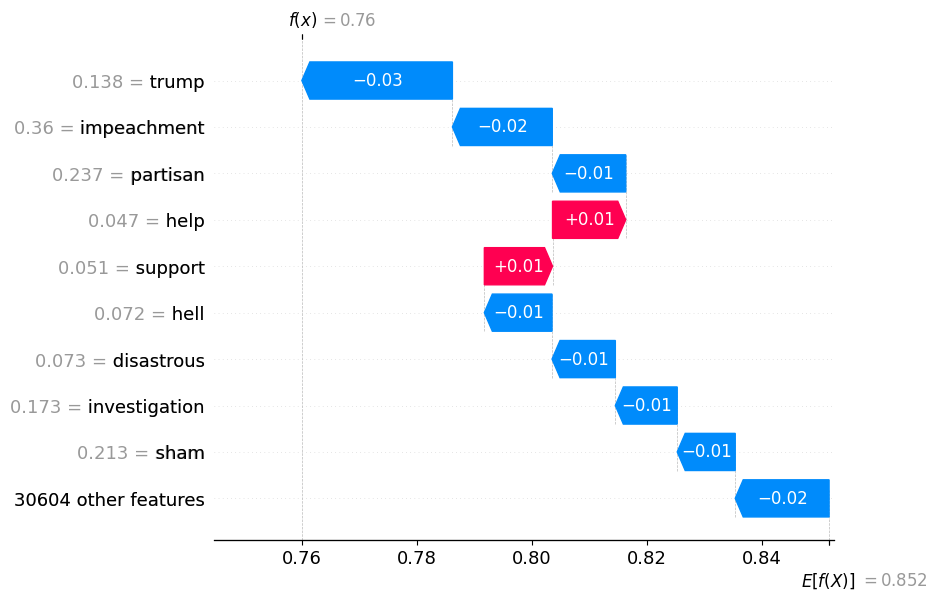

In [11]:
shap.initjs()

ind = 6
print(X_test[ind])
# This amazing documentary gives us a glimpse into the lives of the brave
# women in Cameroun's judicial system-- policewomen, lawyers and judges. Despite
# tremendous difficulties-- lack of means, the desperate poverty of the people, multiple
# languages and multiple legal precedents depending on the region of the country and
# the religious/ethnic background of the plaintiffs and defendants-- these brave,
# strong women are making a difference. [...]

shap.plots.waterfall(shap_values[ind,:,1])

anonymous companies buying single family homes american cities christopher robinson plays juan guzman voids achievement moments explosion credit carlos gonzales lighting voids week present special episode reveal audio drama inspired investigation deadly explosion mississippi shipyard radio play lighting voids produced partners storyworks deconstructed mystery based real events real people story starts hospital burn ward young shipyard worker named bram ates slips dream state flashback takes listeners vt halter shipyard escatawpa mississippi back day shipyard explosion left two dead final part week explosion clyde payne tenacious osha director arrives site investigate listen story one six care homes recently operated adat shalom board care credit rachel de leon reveal dozens senior care homes broke labor laws continue get medicaid funds medicaid funding continued flow dozens senior care home operators four states cited stealing workers wages breaking labor laws reveal jennifer gollan re

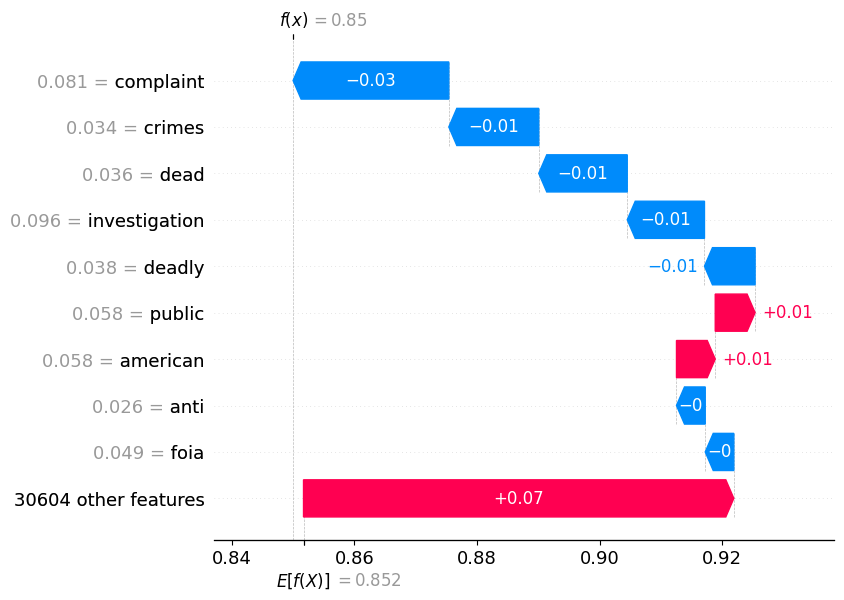

In [17]:
shap.initjs()

ind = 122
print(X_test[ind])
shap.plots.waterfall(shap_values[ind,:,1])

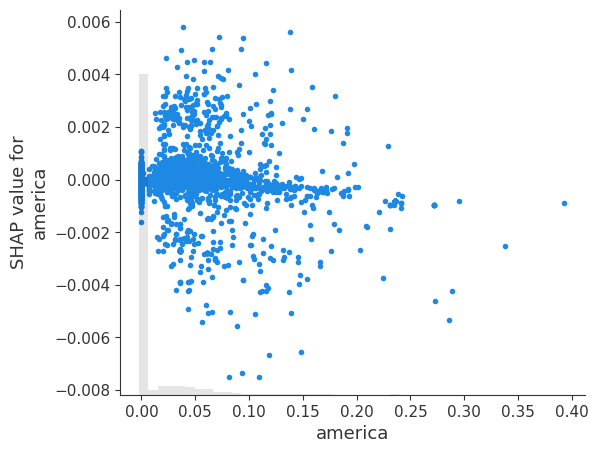

In [18]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("america"),1])


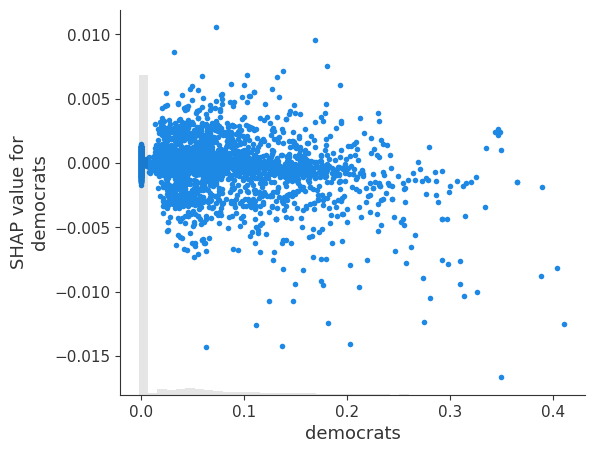

In [16]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("democrats"),1])
